## Importando as bibliotecas

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

## Instanciando o dataframe

In [248]:
df_airbnb = pd.read_csv('airbnb.csv', index_col='id', engine='python', sep =',', encoding="utf-8")
df_airbnb.head()

,host_name,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,neighbourhood,zipcode,latitude,longitude,property_type,...,Wide_entrance_for_guests,Wide_entryway,Wide_hallways,Wifi,Window_guards,Wine_cooler,_toilet,translation_missing:_en.hosting_amenity_49,translation_missing:_en.hosting_amenity_50,m2
id,,,,,,,,,,,,,,,,,,,,,
17878,Matthias,within an hour,1.00,t,t,Copacabana,22020-050,-22.96592,-43.17896,Condominium,...,0,0,0,1,0,0,0,0,0,12169.0
25026,Viviane,within a day,0.91,f,t,Copacabana,22060-020,-22.97712,-43.19045,Apartment,...,0,0,0,1,0,0,0,0,0,12169.0
31560,Renata,within an hour,1.00,t,t,Ipanema,22410-003,-22.98302,-43.21427,Apartment,...,0,0,0,1,0,0,0,1,1,20908.0
35636,Patricia,within an hour,1.00,t,t,Ipanema,22081-020,-22.98816,-43.19359,Apartment,...,0,0,0,1,0,0,0,0,0,20908.0
35764,Patricia Miranda & Paulo,within an hour,1.00,t,t,Copacabana,21031-300,-22.98127,-43.19046,Loft,...,1,1,0,1,0,0,0,0,1,12169.0


## Removendo valores discrepantes

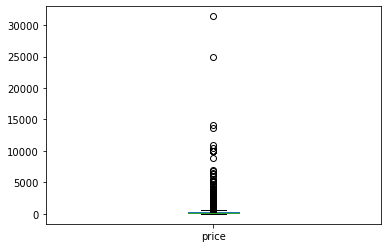

In [249]:
df_airbnb['price'].plot.box()

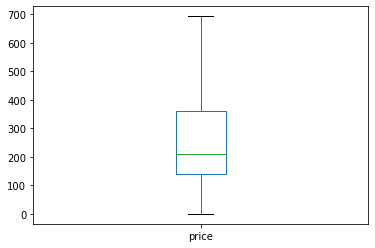

In [250]:
df_airbnb['price'].plot.box(showfliers=False)

In [251]:
df_airbnb['price'].quantile([0, 0.25,0.5,0.75, 1])

0.00        0.0
0.25      139.0
0.50      210.0
0.75      361.0
1.00    31398.0
Name: price, dtype: float64

In [252]:
df_airbnb['price'].quantile([0.1, 0.9]).tolist()

[88.0, 651.0]

In [253]:
min_price = df_airbnb['price'].quantile([0.1]).tolist()[0]
max_price = df_airbnb['price'].quantile([0.9]).tolist()[0]
print("Quantidade de registros no dataframe antes da aplicação do filtro: " + str(df_airbnb.shape[0]))
df_airbnb = df_airbnb[df_airbnb['price'].between(min_price, max_price)]
print("Quantidade de registros no dataframe depois da aplicação do filtro: " + str(df_airbnb.shape[0]))

Quantidade de registros no dataframe antes da aplicação do filtro: 9861
Quantidade de registros no dataframe depois da aplicação do filtro: 8018


## Listando atributos com maior correlação com o preço

In [254]:
# Atributos com maior correlação direta ou inversa com o preço

corr = df_airbnb.corr()
corr['abs_price'] = abs(corr['price'])
corr.sort_values(by = ['abs_price'], ascending = False, inplace = True)
corr['price'][1:51]

bedrooms                                      0.493425
bathrooms                                     0.437874
accommodates                                  0.415701
cleaning_fee                                  0.394085
beds                                          0.345961
guests_included                               0.279153
Free_parking_on_premises                      0.247912
latitude                                     -0.245588
m2                                            0.229604
security_deposit                              0.171845
Washer                                        0.166700
reviews_per_month                            -0.160226
Air_conditioning                              0.147497
Pool                                          0.143971
Cable_TV                                      0.126723
Dryer                                         0.125881
Hot_tub                                       0.125100
Family/kid_friendly                           0.125100
Paid_parki

Text(0.5, 0, 'Correlação')

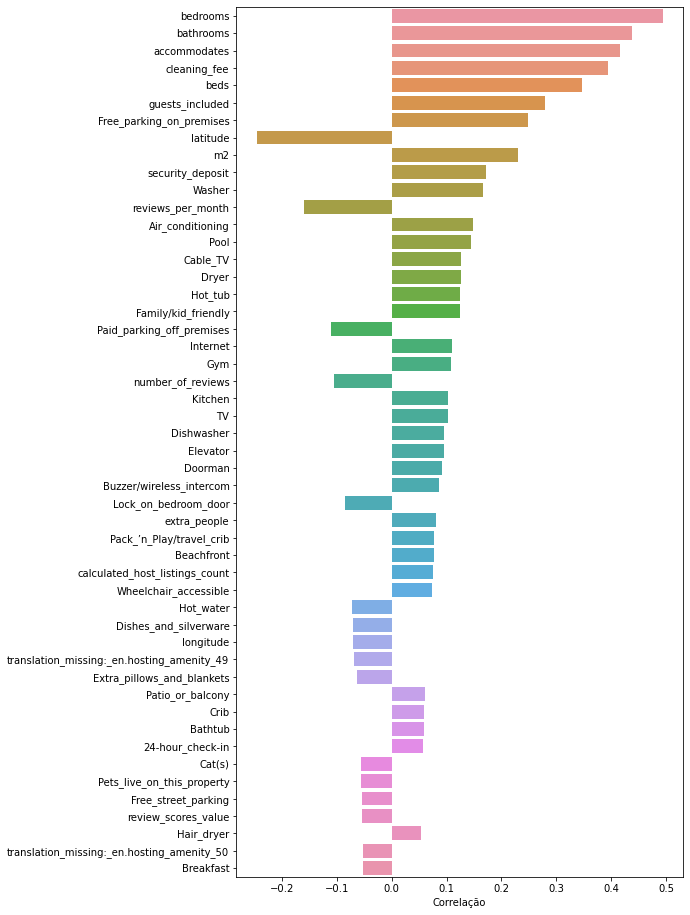

In [255]:
# Visualização de atributos com maior correlação direta ou inversa com o preço

corr = corr['price'][1:51]
plt.figure(figsize=(8, 16))
ax = sns.barplot(corr.values, corr.index)
ax.set_xlabel('Correlação')

## Seleção dos atributos mais relevantes (feature selection)

In [256]:
# Seleção dos vinte atributos mais relevantes à modelagem preditiva

# Atributos redundantes não serão selecionados para não confundir o modelo.
# A seleção será feita com base na força da correlação e na unicidade da característica descrita
# Por exemplo: Bathrooms, bedrooms e beds referem-se à mesma característica: Capacidade de acomodação do imóvel
# Portanto, desses atributos, apenas um será selecionado.
# De acordo com o conhecimento do negócio, para essa característica, será Bedrooms.
# Pois o atributo de maior destaque em relação à acomodação, em anúncios de hospedagem, costuma ser a quantidade de quartos.

# Como o dataset possui 202 atributos e, pela descrição dos atributos mais relevantes, selecionamos os 10% melhores.

top_correlated = ['bedrooms', 'accommodates', 'cleaning_fee', 'guests_included', 'Free_parking_on_premises', 'm2', 'security_deposit', 'Washer', 'Air_conditioning', 'Pool', 'Cable_TV', 'Dryer', 'Hot_tub', 'Family/kid_friendly', 'Paid_parking_off_premises', 'Internet', 'Gym', 'number_of_reviews', 'Kitchen', 'Dishwasher']

In [257]:
# Seleção de atributos auxiliares e alvo

extra = ['latitude', 'longitude', 'neighbourhood', 'room_type', 'property_type']
target = ['price']

In [258]:
# elaboração da lista de features a serem analisadas

features = extra + top_correlated + target
features

['latitude',
 'longitude',
 'neighbourhood',
 'room_type',
 'property_type',
 'bedrooms',
 'accommodates',
 'cleaning_fee',
 'guests_included',
 'Free_parking_on_premises',
 'm2',
 'security_deposit',
 'Washer',
 'Air_conditioning',
 'Pool',
 'Cable_TV',
 'Dryer',
 'Hot_tub',
 'Family/kid_friendly',
 'Paid_parking_off_premises',
 'Internet',
 'Gym',
 'number_of_reviews',
 'Kitchen',
 'Dishwasher',
 'price']

In [259]:
df_airbnb = df_airbnb[features]
df_airbnb

,latitude,longitude,neighbourhood,room_type,property_type,bedrooms,accommodates,cleaning_fee,guests_included,Free_parking_on_premises,...,Dryer,Hot_tub,Family/kid_friendly,Paid_parking_off_premises,Internet,Gym,number_of_reviews,Kitchen,Dishwasher,price
id,,,,,,,,,,,,,,,,,,,,,
17878,-22.96592,-43.17896,Copacabana,Entire home/apt,Condominium,2.0,5,378.0,2,0,...,0,1,1,1,1,0,243,1,0,332.0
25026,-22.97712,-43.19045,Copacabana,Entire home/apt,Apartment,1.0,2,250.0,2,0,...,0,0,1,0,1,0,235,1,0,160.0
31560,-22.98302,-43.21427,Ipanema,Entire home/apt,Apartment,1.0,3,84.0,2,0,...,0,0,0,0,1,0,271,1,0,273.0
35636,-22.98816,-43.19359,Ipanema,Entire home/apt,Apartment,1.0,3,172.0,2,0,...,0,0,1,0,1,0,169,1,0,378.0
35764,-22.98127,-43.19046,Copacabana,Entire home/apt,Loft,1.0,2,140.0,2,0,...,0,0,1,1,0,0,316,1,0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40009653,-22.98304,-43.19569,Copacabana,Entire home/apt,Apartment,2.0,6,150.0,2,0,...,1,0,0,0,0,0,1,1,0,449.0
40025707,-22.97132,-43.18929,Copacabana,Entire home/apt,Apartment,1.0,4,140.0,2,0,...,0,0,1,0,0,0,1,1,0,101.0
40033232,-22.91599,-43.17894,Santa Teresa,Entire home/apt,Apartment,0.0,4,120.0,2,0,...,0,0,0,0,0,0,1,1,0,109.0


## Análise exploratória dos dados (EDA) e filtragem

In [260]:
# Mapa de calor - Concentração de anúncios por bairros

m=folium.Map([-22.92538,-43.29582],zoom_start=12)
HeatMap(df_airbnb[['latitude','longitude']],radius=8,gradient={0.25:'blue',0.5:'purple',0.75:'orange',1.0:'red'}).add_to(m)
display(m)

Text(0.5, 0, 'Média de preço por bairro')

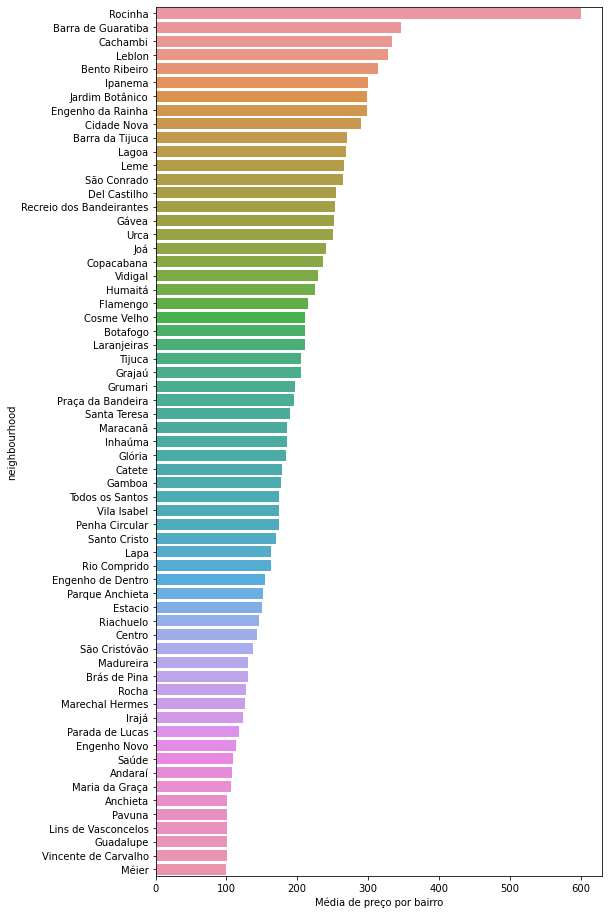

In [261]:
# Exibindo a média de preços dos anúncios por bairro

df_plot = pd.DataFrame(data=df_airbnb.groupby("neighbourhood")["price"].mean())
df_plot.sort_values(by="price", ascending=False, inplace=True)
df_plot.reset_index(inplace=True)
plt.figure(figsize=(8, 16))
ax = sns.barplot(y='neighbourhood', x='price', data=df_plot)
ax.set_xlabel('Média de preço por bairro')

Text(0.5, 0, 'Contagem de anúncios por bairro')

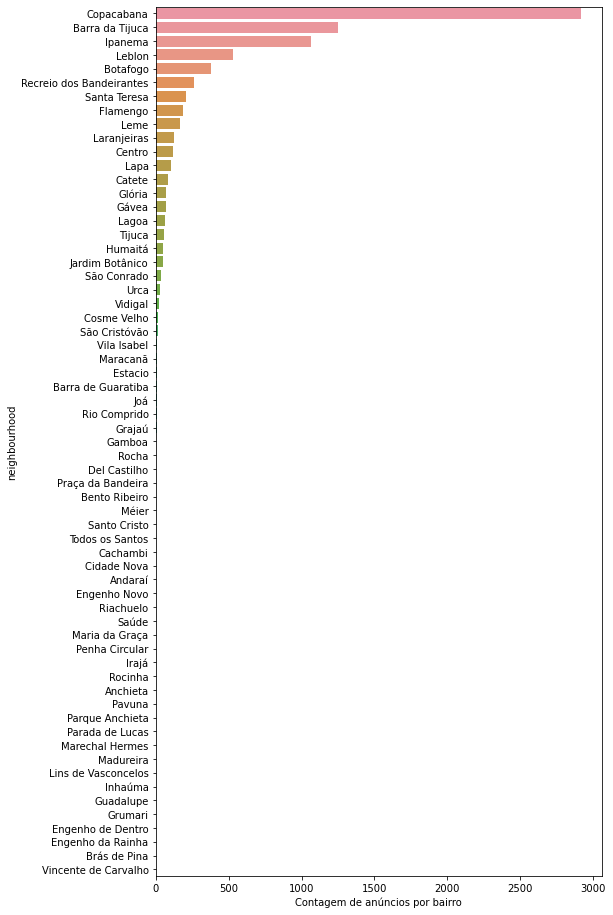

In [262]:
# Exibindo a contagem de anúncios por bairro

df_plot = pd.DataFrame(data=df_airbnb.groupby("neighbourhood")["price"].count())
df_plot.sort_values(by="price", ascending=False, inplace=True)
df_plot.reset_index(inplace=True)
plt.figure(figsize=(8, 16))
ax = sns.barplot(y='neighbourhood', x='price', data=df_plot)
ax.set_xlabel('Contagem de anúncios por bairro')

In [263]:
# O bairro do Joá produziu uma distorção nas estatísticas, pois possui poucos anúncios, porém com uma média de valores bastante alta.
# Além disso, observamos uma grande quantidade de bairros com poucos anúncios, o que poderia causar distorções semelhantes.
# Outros exemplos: Barra de Guaratiba, Rio Comprido e Bento Ribeiro.
# Pelo conhecimento do negócio, é sabido que essas regiões não possuem um valor condizente com suas respectivas médias.
# Portanto, decidiremos por analisar apenas 25% dos bairros com a maior quantidade de anúncios, para evitar esse tipo de distorção.

bairros_validos = df_plot['neighbourhood'].head(int(len(df_plot)*(0.3))).to_list()
bairros_validos

['Copacabana',
 'Barra da Tijuca',
 'Ipanema',
 'Leblon',
 'Botafogo',
 'Recreio dos Bandeirantes',
 'Santa Teresa',
 'Flamengo',
 'Leme',
 'Laranjeiras',
 'Centro',
 'Lapa',
 'Catete',
 'Glória',
 'Gávea',
 'Lagoa',
 'Tijuca',
 'Humaitá']

In [264]:
# Aplicando o filtro no dataframe

df_airbnb = df_airbnb[df_airbnb['neighbourhood'].isin(bairros_validos)]
df_airbnb.shape

(7707, 26)

In [265]:
df_airbnb.describe()

,latitude,longitude,bedrooms,accommodates,cleaning_fee,guests_included,Free_parking_on_premises,m2,security_deposit,Washer,...,Dryer,Hot_tub,Family/kid_friendly,Paid_parking_off_premises,Internet,Gym,number_of_reviews,Kitchen,Dishwasher,price
count,7707.000000,7707.000000,7707.000000,7707.000000,7707.000000,7707.000000,7707.000000,7707.000000,7707.000000,7707.000000,...,7707.000000,7707.000000,7707.000000,7707.000000,7707.000000,7707.000000,7707.000000,7707.000000,7707.000000,7707.000000
mean,-22.973012,-43.229607,1.464902,4.084728,143.312443,2.209290,0.304009,13036.862333,591.634618,0.619696,...,0.175555,0.063449,0.504866,0.231218,0.343065,0.179577,23.675230,0.931361,0.037498,251.213961
std,0.024200,0.080703,0.854846,1.948256,79.584970,1.558423,0.460016,4883.961279,1229.158658,0.485493,...,0.380466,0.243784,0.500009,0.421639,0.474764,0.383860,37.133729,0.252855,0.189992,132.302694
min,-23.032600,-43.523750,0.000000,1.000000,0.000000,1.000000,0.000000,3277.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,88.000000
25%,-22.984530,-43.222190,1.000000,2.000000,100.000000,1.000000,0.000000,9334.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,151.000000
50%,-22.976250,-43.192070,1.000000,4.000000,150.000000,2.000000,0.000000,12169.000000,400.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,210.000000
75%,-22.964380,-43.184545,2.000000,5.000000,180.000000,3.000000,1.000000,12169.000000,800.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,27.000000,1.000000,0.000000,319.000000
max,-22.896090,-43.164160,8.000000,16.000000,672.000000,15.000000,1.000000,23625.000000,20991.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,372.000000,1.000000,1.000000,651.000000


Text(0.5, 0, 'Média de preço por bairro')

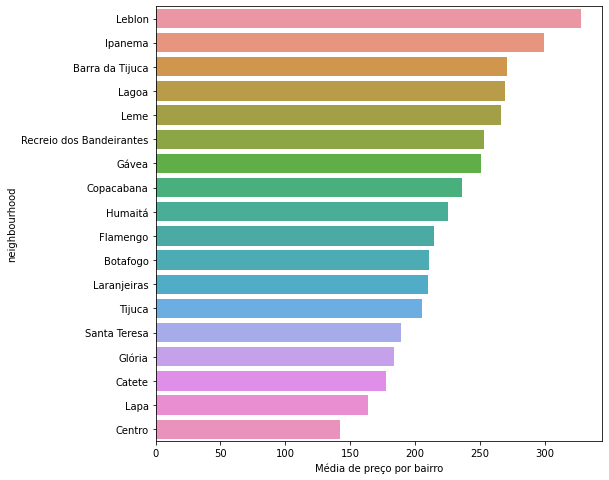

In [266]:
# Exibindo a média de preços dos anúncios por bairro - apenas com os bairros com mais anúncios

df_plot = pd.DataFrame(data=df_airbnb.groupby("neighbourhood")["price"].mean())
df_plot.sort_values(by="price", ascending=False, inplace=True)
df_plot.reset_index(inplace=True)
df_plot = df_plot[df_plot['neighbourhood'].isin(bairros_validos)]
plt.figure(figsize=(8, 8))
ax = sns.barplot(y='neighbourhood', x='price', data=df_plot)
ax.set_xlabel('Média de preço por bairro')

Text(0.5, 0, 'Contagem de anúncios por bairro')

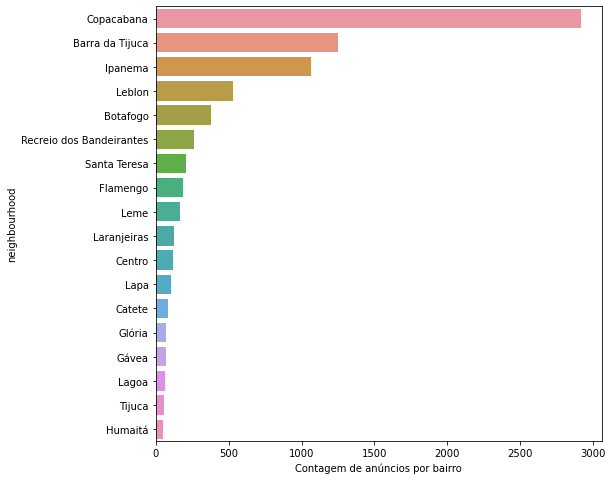

In [267]:
# Exibindo a contagem de anúncios por bairro - apenas com os bairros com mais anúncios

df_plot = pd.DataFrame(data=df_airbnb.groupby("neighbourhood")["price"].count())
df_plot.sort_values(by="price", ascending=False, inplace=True)
df_plot.reset_index(inplace=True)
df_plot = df_plot[df_plot['neighbourhood'].isin(bairros_validos)]
plt.figure(figsize=(8, 8))
ax = sns.barplot(y='neighbourhood', x='price', data=df_plot)
ax.set_xlabel('Contagem de anúncios por bairro')

In [268]:
df_properties_statistics = pd.DataFrame(data=df_airbnb.groupby("property_type")["price"].count())
df_properties_statistics.rename(columns={"price":"quantidade"}, inplace=True)
df_properties_statistics.sort_values(by="quantidade", ascending=False, inplace=True)
df_properties_statistics

,quantidade
property_type,
Apartment,6207
Condominium,544
Serviced apartment,304
Loft,229
House,220
Guest suite,45
Aparthotel,38
Guesthouse,31
Townhouse,20


Text(0.5, 0, 'Contagem de anúncios por tipos de propriedades - com filtro')

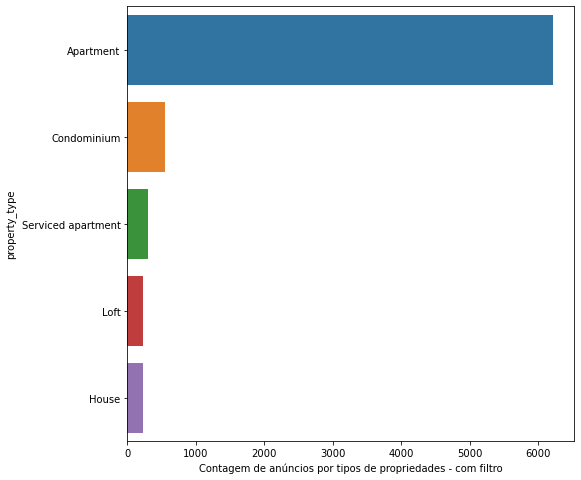

In [269]:
tipos_de_propriedades_validas = df_properties_statistics.head(int(len(df_properties_statistics)*(0.25)))
plt.figure(figsize=(8, 8))
ax = sns.barplot(tipos_de_propriedades_validas.quantidade, tipos_de_propriedades_validas.index)
ax.set_xlabel('Contagem de anúncios por tipos de propriedades - com filtro')

In [270]:
# Aplicando o filtro de tipos de propriedades no dataframe

df_airbnb = df_airbnb[df_airbnb['property_type'].isin(tipos_de_propriedades_validas.index.to_list())]
df_airbnb.shape

(7504, 26)

Text(0.5, 0, 'Contagem de anúncios por tipos de acomodação')

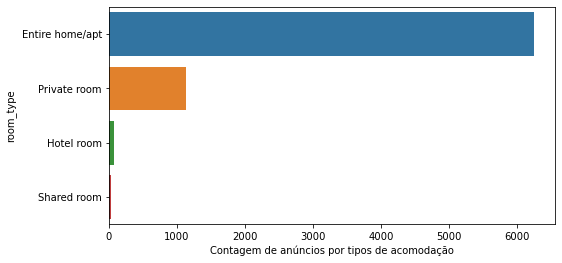

In [271]:
df_plot = pd.DataFrame(data=df_airbnb.groupby("room_type")["price"].count())
df_plot.rename(columns={"price":"quantidade"}, inplace=True)
df_plot.sort_values(by="quantidade", ascending=False, inplace=True)
plt.figure(figsize=(8, 4))
ax = sns.barplot(df_plot.quantidade, df_plot.index)
ax.set_xlabel('Contagem de anúncios por tipos de acomodação')

In [272]:
df_plot

,quantidade
room_type,
Entire home/apt,6251
Private room,1140
Hotel room,75
Shared room,38


Text(0.5, 0, 'Contagem de anúncios por quantidade de dormitórios')

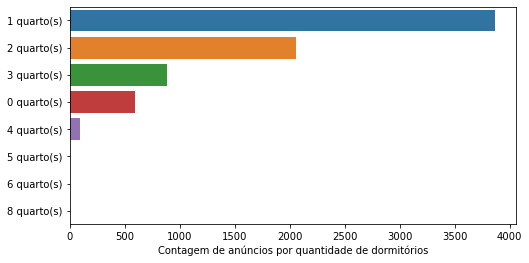

In [273]:
df_plot = pd.DataFrame(data=df_airbnb.groupby("bedrooms")["price"].count())
df_plot.rename(columns={"price":"quantidade"}, inplace=True)
df_plot.sort_values(by="quantidade", ascending=False, inplace=True)
#df_plot.reset_index(inplace=True)
#df_plot.index.astype(str).tolist()
plt.figure(figsize=(8, 4))
ax = sns.barplot(df_plot['quantidade'], df_plot.index.astype('int32').astype(str) + " quarto(s)")
ax.set_xlabel('Contagem de anúncios por quantidade de dormitórios')

In [274]:
# Aplicando o filtro de quantidade de dormitórios no dataframe

print("Quantidade de registros no dataframe antes da aplicação do filtro: " + str(df_airbnb.shape[0]))
qt_dormitorios = df_plot.head(int(len(df_plot)*(2/3))).index.to_list()
df_airbnb = df_airbnb[df_airbnb['bedrooms'].isin(qt_dormitorios)]
print("Quantidade de registros no dataframe depois da aplicação do filtro: " + str(df_airbnb.shape[0]))

Quantidade de registros no dataframe antes da aplicação do filtro: 7504
Quantidade de registros no dataframe depois da aplicação do filtro: 7497


Text(0.5, 0, 'Contagem de anúncios por quantidade de dormitórios - com filtro')

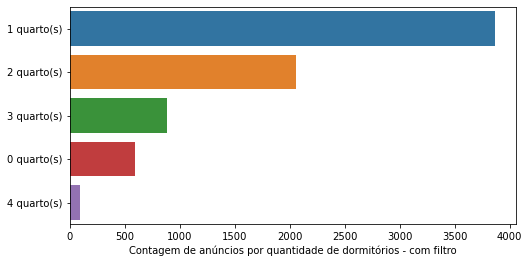

In [275]:
df_plot = pd.DataFrame(data=df_airbnb.groupby("bedrooms")["price"].count())
df_plot.rename(columns={"price":"quantidade"}, inplace=True)
df_plot.sort_values(by="quantidade", ascending=False, inplace=True)
plt.figure(figsize=(8, 4))
ax = sns.barplot(df_plot['quantidade'], df_plot.index.astype('int32').astype(str) + " quarto(s)")
ax.set_xlabel('Contagem de anúncios por quantidade de dormitórios - com filtro')

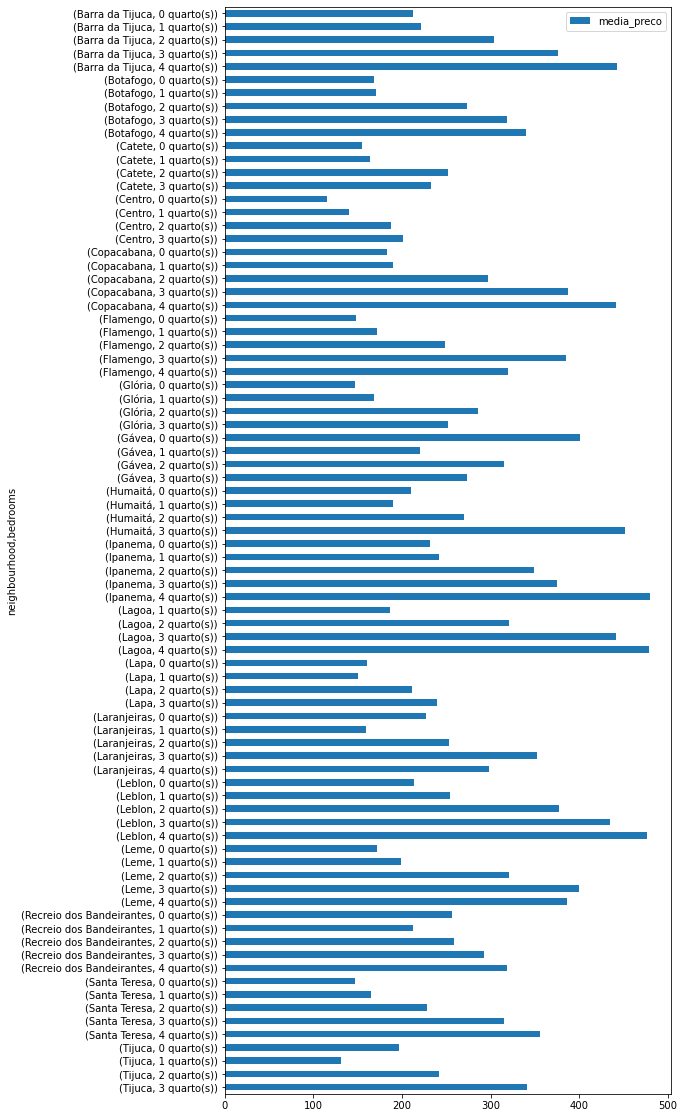

In [276]:
# Média de preço por quartos por bairro

df_plot = pd.DataFrame(df_airbnb.groupby(['neighbourhood', 'bedrooms'])['price'].mean())
df_plot.rename(columns={"price":"media_preco"}, inplace=True)
df_plot.sort_index(inplace=True, ascending=False)
df_plot.reset_index(inplace=True)
df_plot['bedrooms'] = df_plot['bedrooms'].astype('int32').astype(str) + ' quarto(s)'
df_plot.set_index(['neighbourhood', 'bedrooms'], inplace=True)
df_plot.plot.barh(figsize=(8, 20))

## Convertendo os atributos categóricos em quantitativos discretos

In [277]:
df_airbnb_ml = df_airbnb
for column in df_airbnb_ml.columns:
    if str(df_airbnb_ml[column].dtype) not in ['float64', 'int64']:
        df_airbnb_ml[column] = df_airbnb_ml[column].map \
        (dict(zip(df_airbnb_ml[column].unique().tolist(),range(len(df_airbnb_ml[column].unique().tolist())))))
df_airbnb_ml

,latitude,longitude,neighbourhood,room_type,property_type,bedrooms,accommodates,cleaning_fee,guests_included,Free_parking_on_premises,...,Dryer,Hot_tub,Family/kid_friendly,Paid_parking_off_premises,Internet,Gym,number_of_reviews,Kitchen,Dishwasher,price
id,,,,,,,,,,,,,,,,,,,,,
17878,-22.96592,-43.17896,0,0,0,2.0,5,378.0,2,0,...,0,1,1,1,1,0,243,1,0,332.0
25026,-22.97712,-43.19045,0,0,1,1.0,2,250.0,2,0,...,0,0,1,0,1,0,235,1,0,160.0
31560,-22.98302,-43.21427,1,0,1,1.0,3,84.0,2,0,...,0,0,0,0,1,0,271,1,0,273.0
35636,-22.98816,-43.19359,1,0,1,1.0,3,172.0,2,0,...,0,0,1,0,1,0,169,1,0,378.0
35764,-22.98127,-43.19046,0,0,2,1.0,2,140.0,2,0,...,0,0,1,1,0,0,316,1,0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40009653,-22.98304,-43.19569,0,0,1,2.0,6,150.0,2,0,...,1,0,0,0,0,0,1,1,0,449.0
40025707,-22.97132,-43.18929,0,0,1,1.0,4,140.0,2,0,...,0,0,1,0,0,0,1,1,0,101.0
40033232,-22.91599,-43.17894,10,0,1,0.0,4,120.0,2,0,...,0,0,0,0,0,0,1,1,0,109.0


## Exibindo a matriz de correlação dos dados

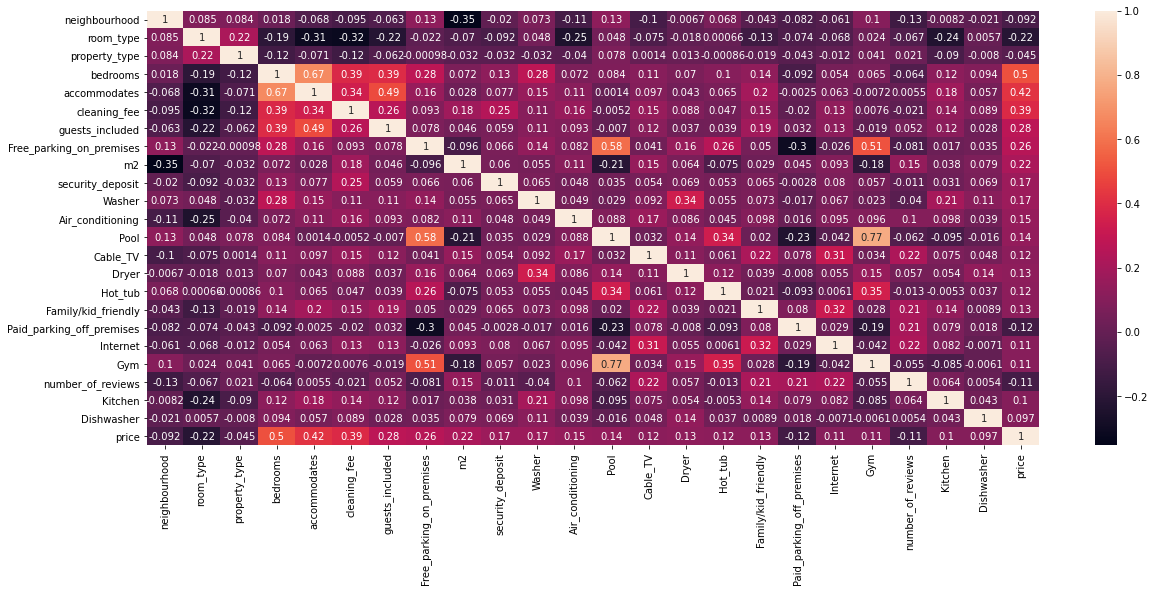

In [278]:
corr = df_airbnb_ml.drop(columns=['latitude', 'longitude']).corr()
corr.style.background_gradient(cmap='coolwarm')
plt.figure(figsize=(20,8))
sns.heatmap(corr,annot=True)

## Selecionando amostragem dos dados

In [279]:
df_airbnb_ml = df_airbnb_ml.head(7000)
print("Quantidade final de registros: "+ str(df_airbnb_ml.shape[0]))

Quantidade final de registros: 7000


## Salvando o dataframe resultante para a etapa seguinte

In [280]:
df_airbnb_ml.to_csv('airbnb_ml.csv')